# Pre-process on Client Train Images 

In [1]:
from PIL import Image
from IPython.display import display
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pylab, random, os, math, sklearn
import numpy as np
import tensorflow as tf

# To cancel scientific notation
np.set_printoptions(suppress=True)

%matplotlib inline
# %matplotlib tk
%config InlineBackend.figure_format = 'retina'

# To set plotting style
plt.style.use("classic")
plt.style.use("bmh")
plt.style.use("seaborn-whitegrid")

# To hide warnings
import warnings
warnings.filterwarnings("ignore")

# 1. Extract Labels from XML Files

In [2]:
PATH = "/Users/ray/Desktop/crack-images/LCMS-Range-Labeled"
dirs = os.listdir(PATH)
dirs

['.DS_Store', 'images', 'annotations', 'anno-image']

In [3]:
ANNO_PATH = os.path.join(PATH, "annotations")
ANNO_PATH

'/Users/ray/Desktop/crack-images/LCMS-Range-Labeled/annotations'

In [4]:
IMG_PATH = os.path.join(PATH, "images")
IMG_PATH

'/Users/ray/Desktop/crack-images/LCMS-Range-Labeled/images'

## 1.1 A Trial on a Single Image

Let's have look at a sample XML file:

In [5]:
xml_list = os.listdir(ANNO_PATH)
sample_xml = xml_list[0]
with open(os.path.join(ANNO_PATH, sample_xml)) as file:
    print(file.read())

<annotation>
	<folder>images</folder>
	<filename>000006450000.JPG</filename>
	<path>E:\Work\AI\data\pavement\training\images\000006450000.JPG</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>520</width>
		<height>1250</height>
		<depth>1</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>long</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>278</xmin>
			<ymin>50</ymin>
			<xmax>338</xmax>
			<ymax>188</ymax>
		</bndbox>
	</object>
	<object>
		<name>long</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>267</xmin>
			<ymin>275</ymin>
			<xmax>308</xmax>
			<ymax>469</ymax>
		</bndbox>
	</object>
	<object>
		<name>long</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>262</xmin>
			<ymin>602</ymin>
			<xmax>301</xmax>
			<ymax>766</ymax>
		</bndbox>
	</object>
	<object>
		<name>

Use beautiful Soup to parse the file:

Number of cracks:

In [6]:
from bs4 import BeautifulSoup

with open(os.path.join(ANNO_PATH, sample_xml)) as file:
    soup = BeautifulSoup(file.read(), 'xml')
    
len(soup.find_all("object"))

4

Name of the image file:

In [7]:
filename = soup.filename.text
filename

'000006450000.JPG'

Have a look at the image:

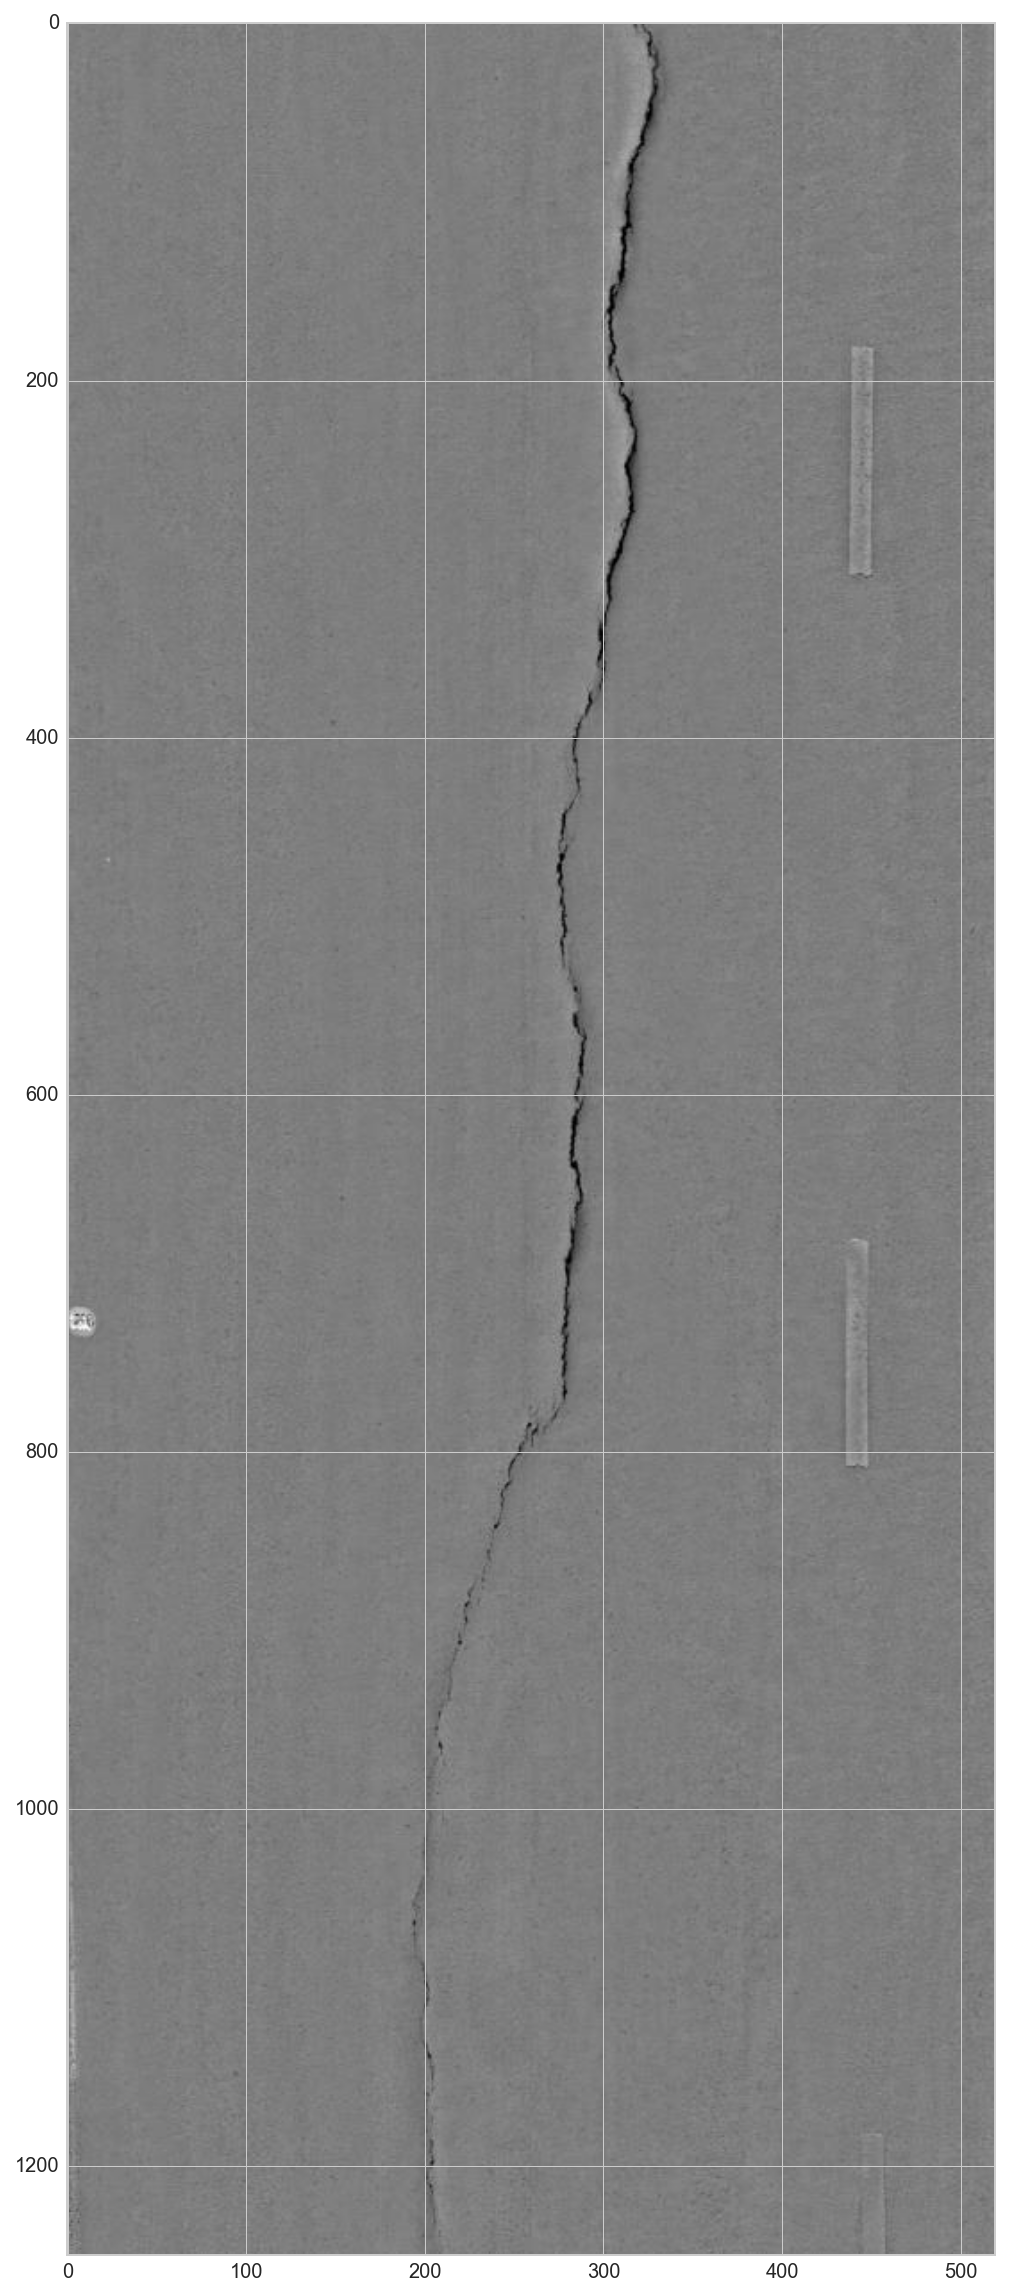

In [8]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

img = img_to_array(load_img(os.path.join(IMG_PATH, filename))).astype(int)
plt.figure(figsize=(10,20))
plt.imshow(img)
plt.show()

Image size:

In [9]:
img.shape

(1250, 520, 3)

Crack position and crack type:

In [10]:
for crack in soup.find_all("object"):
    name = crack.find("name").text
    box = crack.bndbox
    print(f"Type: {name}, xmin: {box.xmin.text}, xmax: {box.xmax.text}, ymin: {box.ymin.text}, ymax: {box.ymax.text}")

Type: long, xmin: 278, xmax: 338, ymin: 50, ymax: 188
Type: long, xmin: 267, xmax: 308, ymin: 275, ymax: 469
Type: long, xmin: 262, xmax: 301, ymin: 602, ymax: 766
Type: long, xmin: 178, xmax: 220, ymin: 978, ymax: 1105


Make annotation on the image:

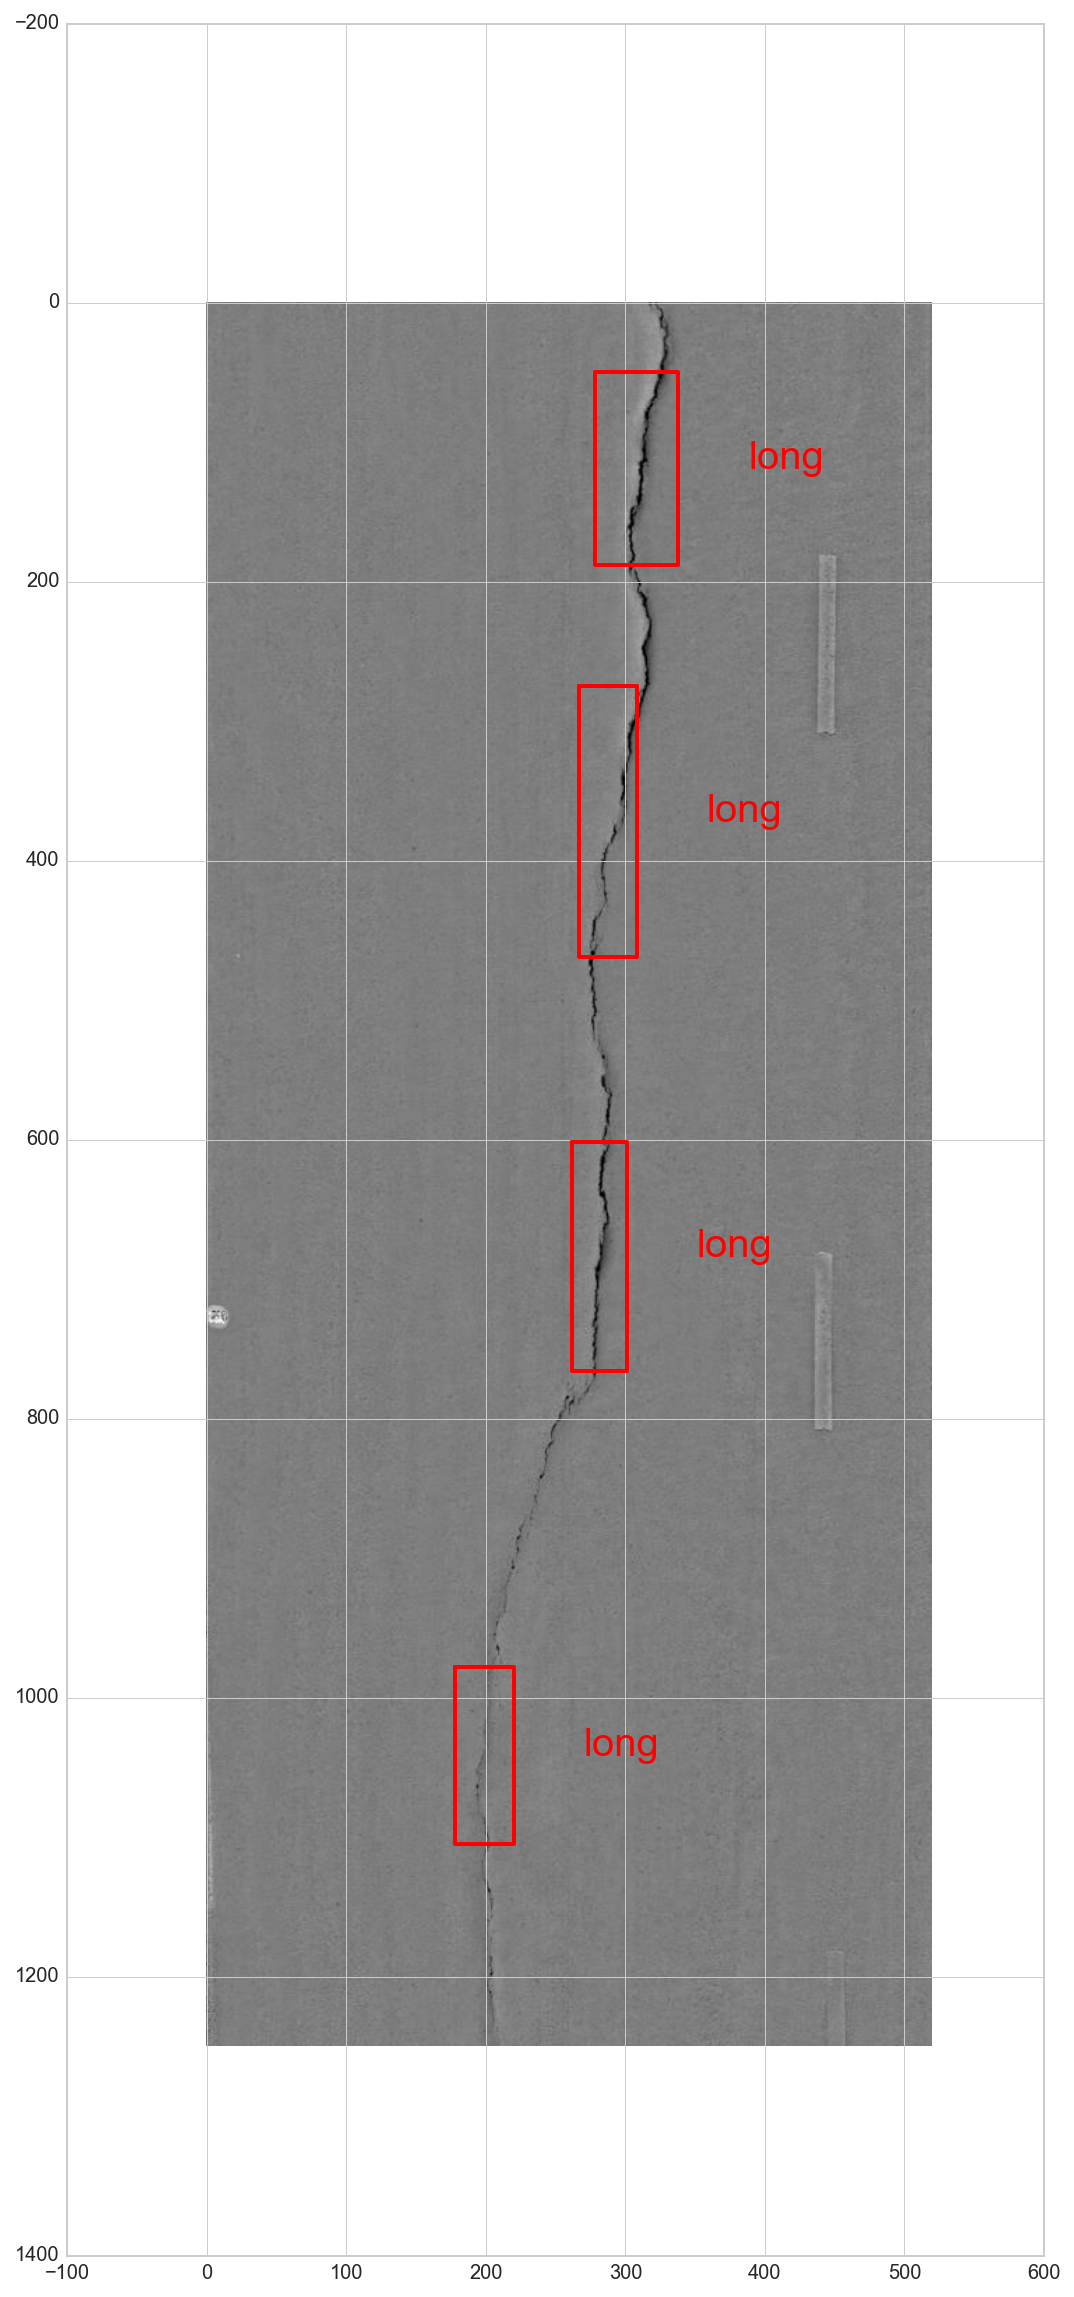

In [11]:
names = []
boxes = []
for crack in soup.find_all("object"):
    names.append(crack.find("name").text)
    box = crack.bndbox
    box = {
        'xmin': int(box.xmin.text), 
        'xmax': int(box.xmax.text), 
        'ymin': int(box.ymin.text), 
        'ymax': int(box.ymax.text)
    }
    boxes.append(box)

plt.figure(figsize=(10,20))
plt.imshow(img)
for name, box in zip(names, boxes):
    x = [box["xmin"]] + [box["xmax"]] * 2 + [box["xmin"]] * 2
    y = [box["ymin"]] * 2 + [box["ymax"]] * 2 + [box["ymin"]]
    plt.plot(x, y, c="red", linewidth="2")
    plt.text(box["xmax"] + 50, 0.5 * (box["ymin"] + box["ymax"]), name, c="red", fontsize=20)
plt.show()

## 1.2 Process All Images

### 1.2.1 Save Annotated Images

Create directory to save annotated images:

In [12]:
# save_dir_name = "anno-image"
# SAVE_PATH = os.path.join(PATH, save_dir_name)
# try:
#     os.mkdir(SAVE_PATH)
# except:
#     all_files = os.listdir(SAVE_PATH)
#     for file in all_files:
#         os.remove(os.path.join(SAVE_PATH, file))

Save all annotated images:

In [13]:
def save_single_image(img_path, save_path, soup):
    # extract crack name and position
    names = []
    boxes = []
    for crack in soup.find_all("object"):
        names.append(crack.find("name").text)
        box = crack.bndbox
        box = {
            'xmin': int(box.xmin.text), 
            'xmax': int(box.xmax.text), 
            'ymin': int(box.ymin.text), 
            'ymax': int(box.ymax.text)
        }
        boxes.append(box)
    
    # read image
    filename = soup.filename.text
    img = img_to_array(load_img(os.path.join(img_path, filename))).astype(int)
    
    # annotate the image
    fig, ax = plt.subplots(figsize=(10,20))
    ax.imshow(img)
    for name, box in zip(names, boxes):
        x = [box["xmin"]] + [box["xmax"]] * 2 + [box["xmin"]] * 2
        y = [box["ymin"]] * 2 + [box["ymax"]] * 2 + [box["ymin"]]
        ax.plot(x, y, c="red", linewidth="2")
        ax.text(box["xmax"] + 50, 0.5 * (box["ymin"] + box["ymax"]), name, c="red", fontsize=20)
    
    # save image
    fig.savefig(os.path.join(save_path, filename))

The following code will transform all original images into annotated images. Because this process will take a long time, we comment out this code fregment.

In [14]:
# %%capture
# xml_list = os.listdir(ANNO_PATH)
# xml_num = len(xml_list)
# for i, xml in enumerate(xml_list):
#     with open(os.path.join(ANNO_PATH, xml)) as file:
#         soup = BeautifulSoup(file.read(), 'xml')
#         save_single_image(IMG_PATH, SAVE_PATH, soup)

### 1.2.2 Save All Labels In a List

In [15]:
filenames = []
images = []
labels = []
for xml in xml_list:
    with open(os.path.join(ANNO_PATH, xml)) as file:
        soup = BeautifulSoup(file.read(), 'xml')
        filename = soup.filename.text
        filenames.append(filename)
        img = img_to_array(load_img(os.path.join(IMG_PATH, filename))).astype(int)
        images.append(img)
        names = set()
        for crack in soup.find_all("object"):
            try:
                names.add(crack.find("name").text)
            except:
                pass
        labels.append(list(names))

Let's have a look at the categories of all labels:

In [16]:
import pandas as pd
labels = pd.DataFrame(labels)
labels

0     1     2
0     long  None  None
1     croc  None  None
2    cross  None  None
3     croc  None  None
4    cross  diag  long
..     ...   ...   ...
115   None  None  None
116   long  None  None
117  cross  long  None
118  cross  None  None
119   None  None  None

[120 rows x 3 columns]

In [17]:
import numpy as np

set(np.concatenate((labels[0].unique(), labels[1].unique(), labels[2].unique())).tolist())

{None, 'croc', 'cross', 'diag', 'long', 'meander', 'rect'}

Let's see how which images are uncracked:

In [18]:
null_label = labels.isnull()
null_label = null_label[0] & null_label[1] & null_label[2]
labels[null_label].index

Int64Index([19, 81, 83, 95, 97, 115, 119], dtype='int64')

For the first trial, we simply use binary classification, namely, cracked and uncracked.

In [19]:
bi_lables = np.ones(null_label.shape[0])
bi_lables[null_label] = 0
bi_lables

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       0.])

# 2. Resize, Graylevel Transformation and Crop on the Original images

## 2.1 Resize

The orginal shape:

In [20]:
images[0].shape

(1250, 520, 3)

The original image:

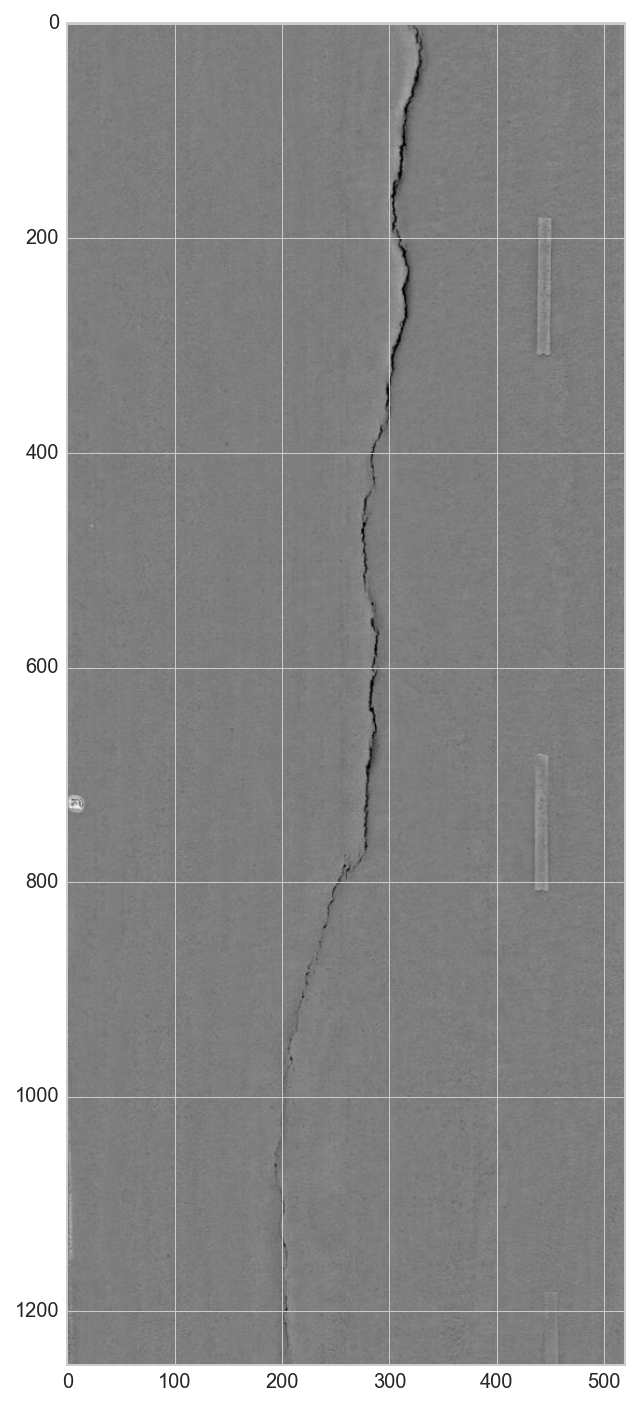

In [21]:
plt.figure(figsize=(5,12.5))
plt.imshow(images[0])
plt.show()

Resize those images to 224 $\times$ 224.

In [22]:
images_resized = [np.array(Image.fromarray(np.uint8(img)).resize((224,224))).astype(int) for img in images]

The output size:

In [23]:
images_resized[0].shape

(224, 224, 3)

Show a sample image.

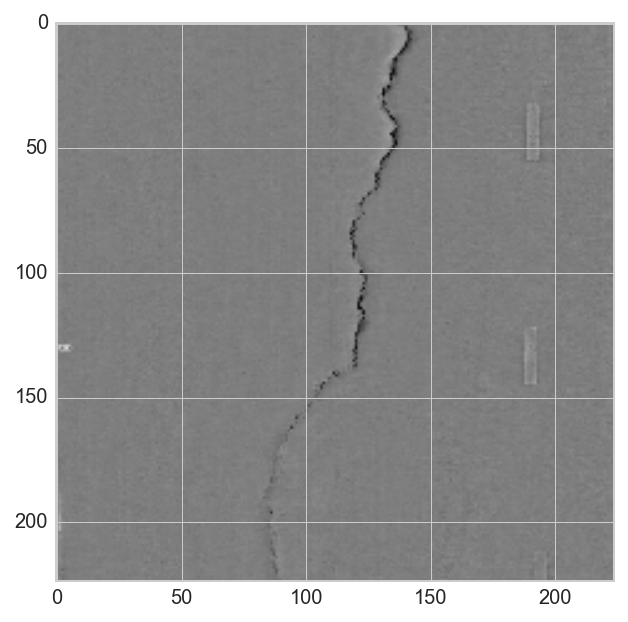

In [24]:
plt.figure(figsize=(5,5))
plt.imshow(images_resized[0])
plt.show()

## 2.2 Graylevel Transformation

Let's have a look at the distribution of the pixel values of some representative figures.

### 2.2.1 Image: `000006450000.JPG`

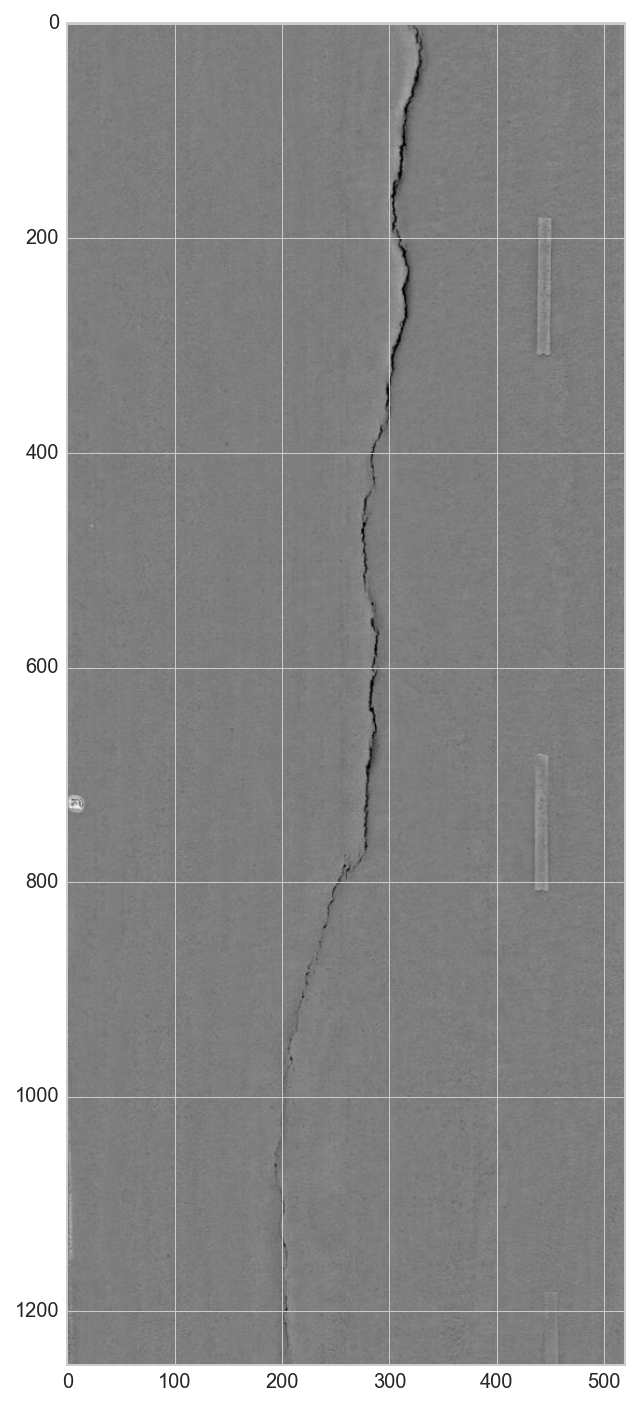

In [25]:
plt.figure(figsize=(5,12.5))
plt.imshow(images[0])
plt.show()

In [26]:
from scipy.stats import describe
describe(images[0].flatten())[1]

(0, 255)

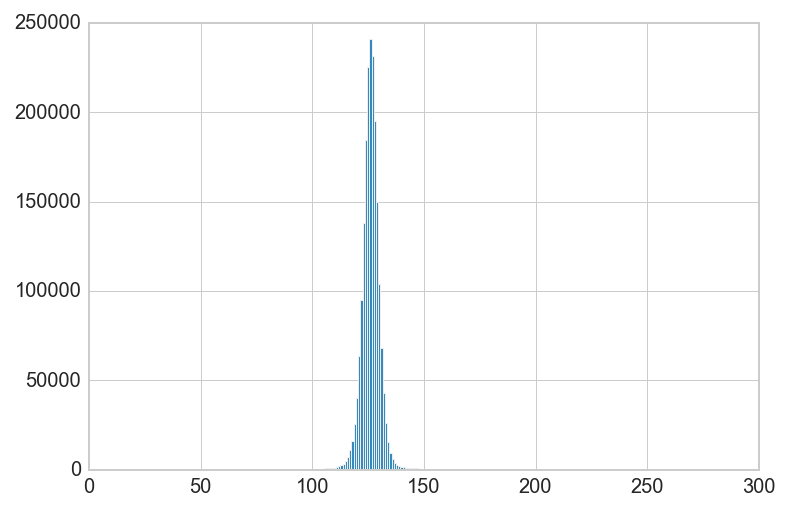

In [27]:
plt.hist(images[0].flatten(),256) 
plt.show()

Clearly, most of the pixel values fall in the range of (100, 150), which are essentailly the grayscale values of normal road surface. 

Note that since the detector used for capturing the cracks is radar-based rather CCD/CMOS-based, the pixel values does represent the real color of the road surface. In fact, pixels which are darker (approaching 0) means the distnce from the surface is farther from the detector (e.g. cracks or some barriers that prevent radar reflection at the edge of the detection range) and pixels which are lighter (approaching 255) means the distnce from the surface is shorter from the detector (e.g. road lane markings or curbs).

Due to this nature, we can multiply all the pixel values by a factor (say, 2.5) to remove all the surface information above the crack.

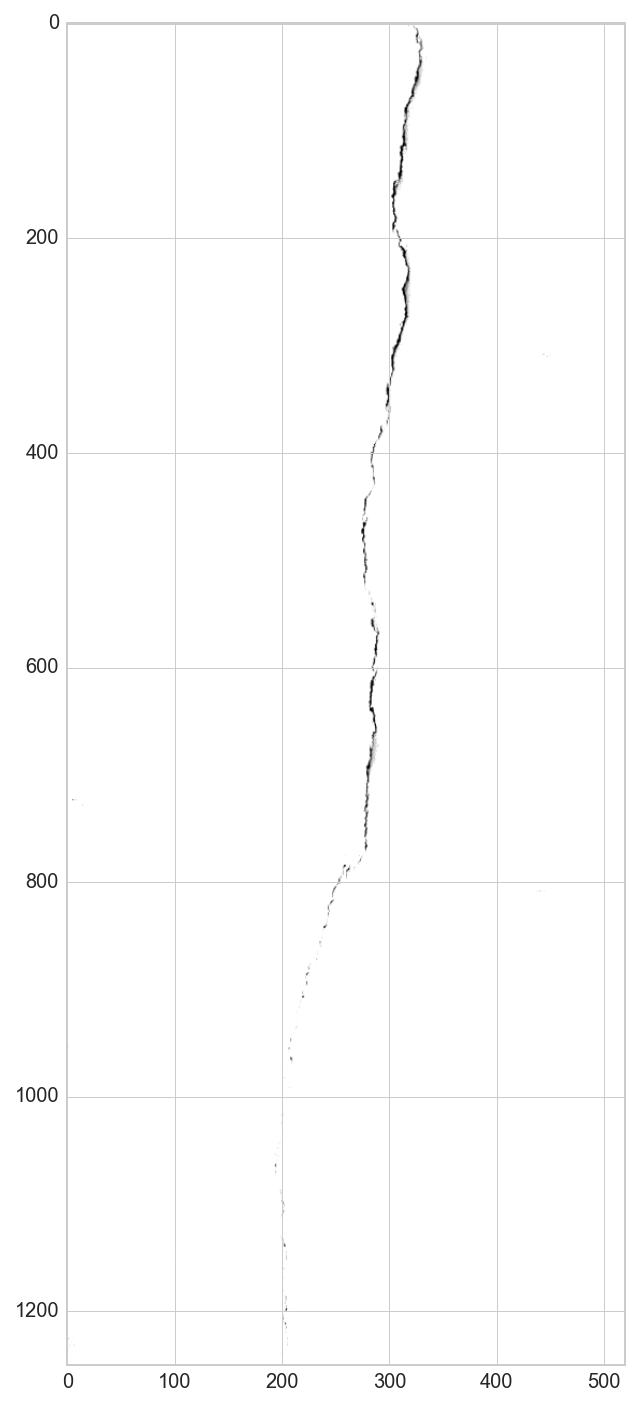

In [28]:
multiplied = np.clip(images[0] * 2.5, 0, 255).astype(int)
plt.figure(figsize=(5,12.5))
plt.imshow(multiplied)
plt.show()

Histogram for all pixels that are not 255:

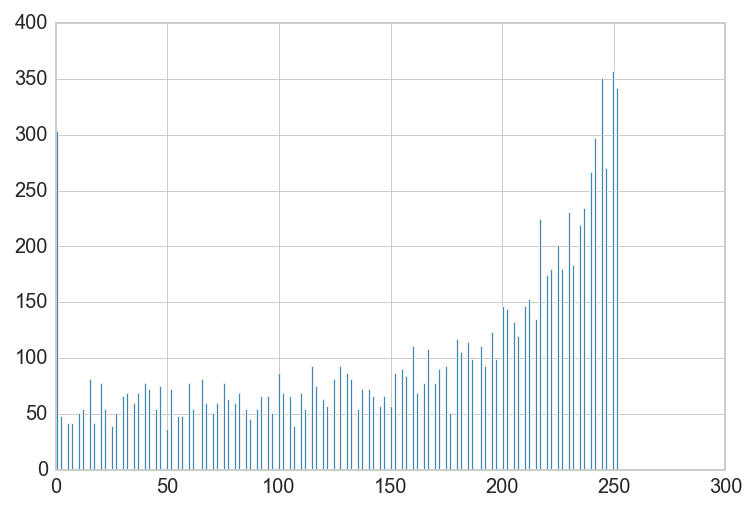

In [29]:
plt.hist(multiplied[multiplied != 255].flatten(),256) 
plt.show()

Let's we can see that only $0.5\%$ of the original information remains.

In [30]:
np.prod(multiplied[multiplied != 255].shape)

10569

In [31]:
np.prod(images[0].shape)

1950000

In [32]:
np.prod(multiplied[multiplied != 255].shape) / np.prod(images[0].shape)

0.00542

### 2.2.2 Image: `000020780000.JPG`

This images as curb at the image edge:

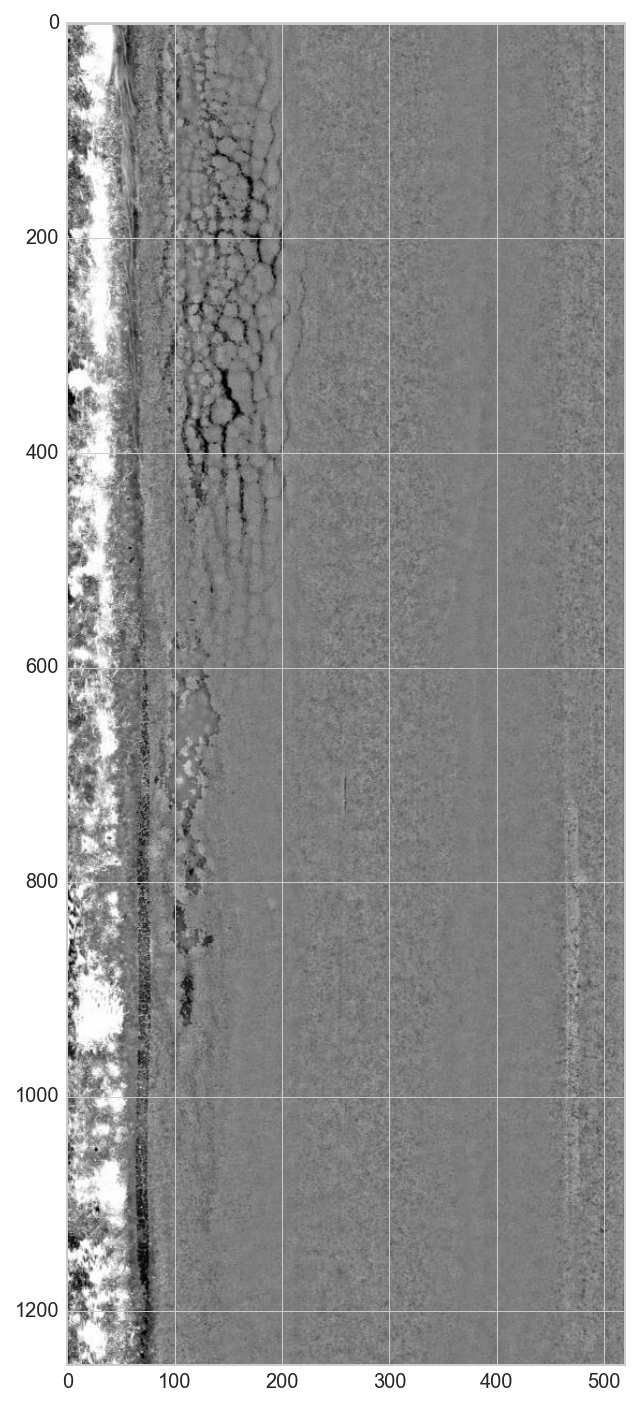

In [33]:
plt.figure(figsize=(5,12.5))
plt.imshow(images[1])
plt.show()

This images has more right-tail values:

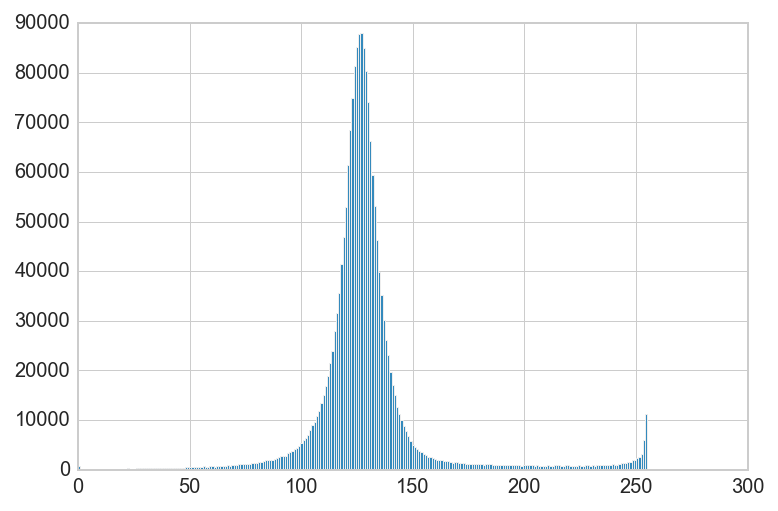

In [34]:
plt.hist(images[1].flatten(),256) 
plt.show()

Multiply the pixel values:

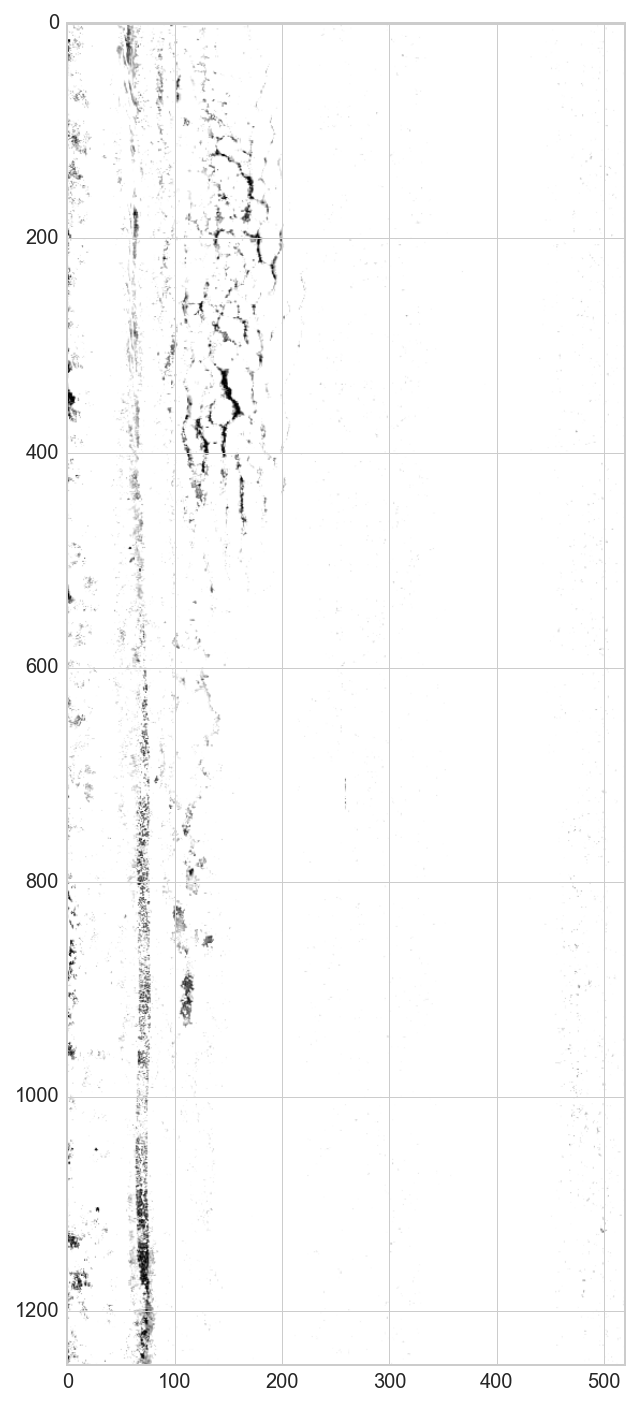

In [35]:
multiplied = np.clip(images[1] * 2.5, 0, 255).astype(int)
plt.figure(figsize=(5,12.5))
plt.imshow(multiplied)
plt.show()

Histogram for all pixels that are not 255:

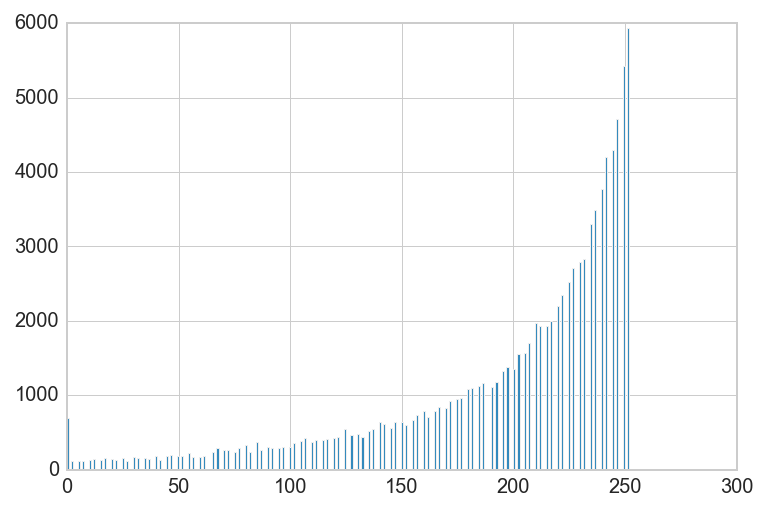

In [36]:
plt.hist(multiplied[multiplied != 255].flatten(),256) 
plt.show()

 $5\%$ of the original information remains.

In [37]:
np.prod(multiplied[multiplied != 255].shape) / np.prod(images[1].shape)

0.05200307692307692

### 2.2.3 Image: `000001850000.JPG`

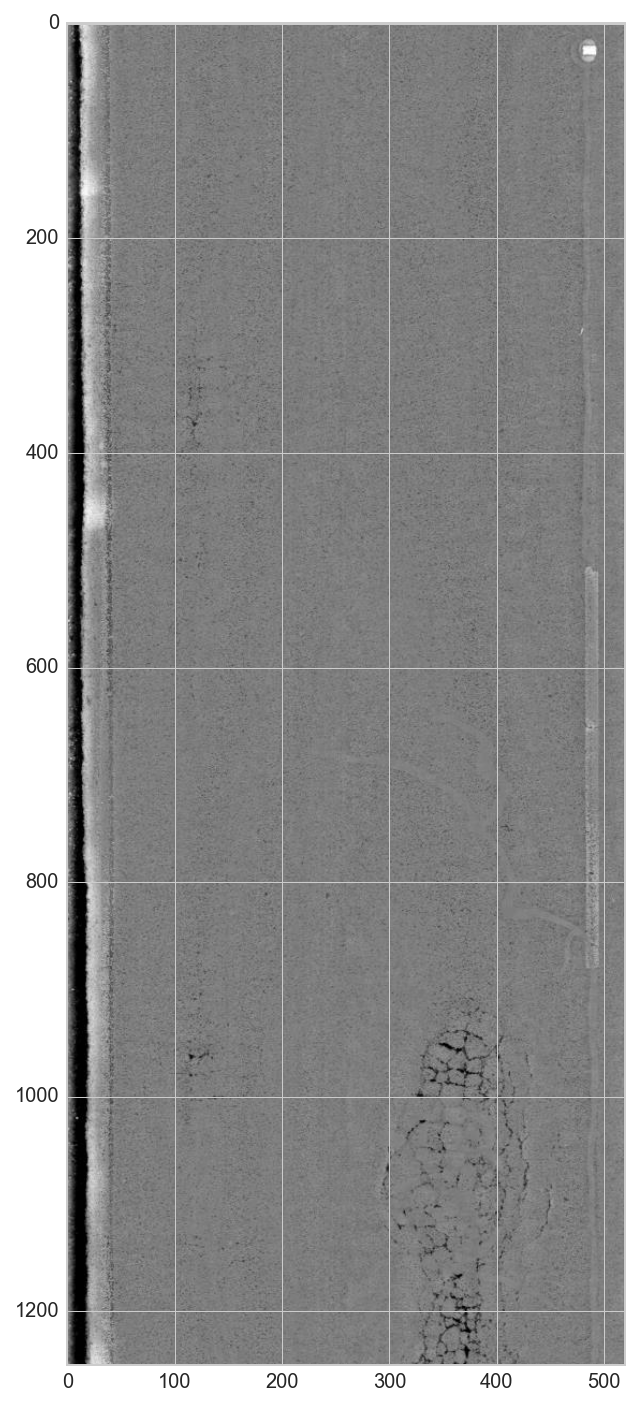

In [38]:
plt.figure(figsize=(5,12.5))
plt.imshow(images[12])
plt.show()

This images has more left-tail values:

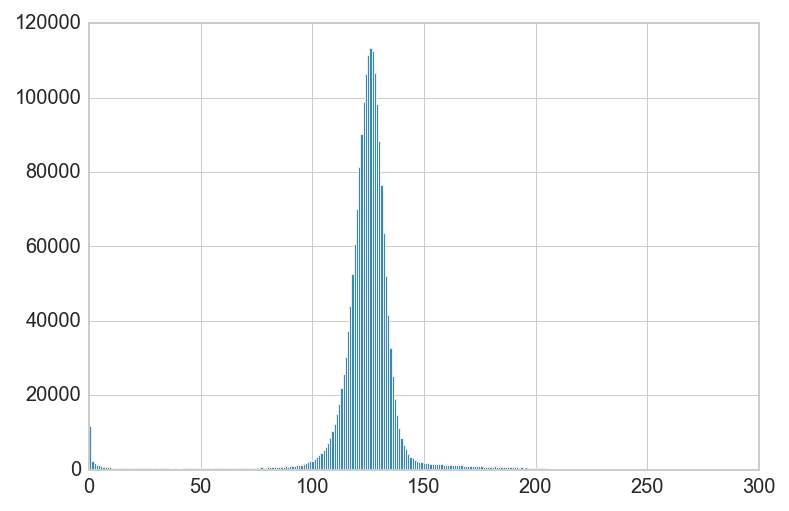

In [39]:
plt.hist(images[12].flatten(),256) 
plt.show()

Multiply the pixel values:

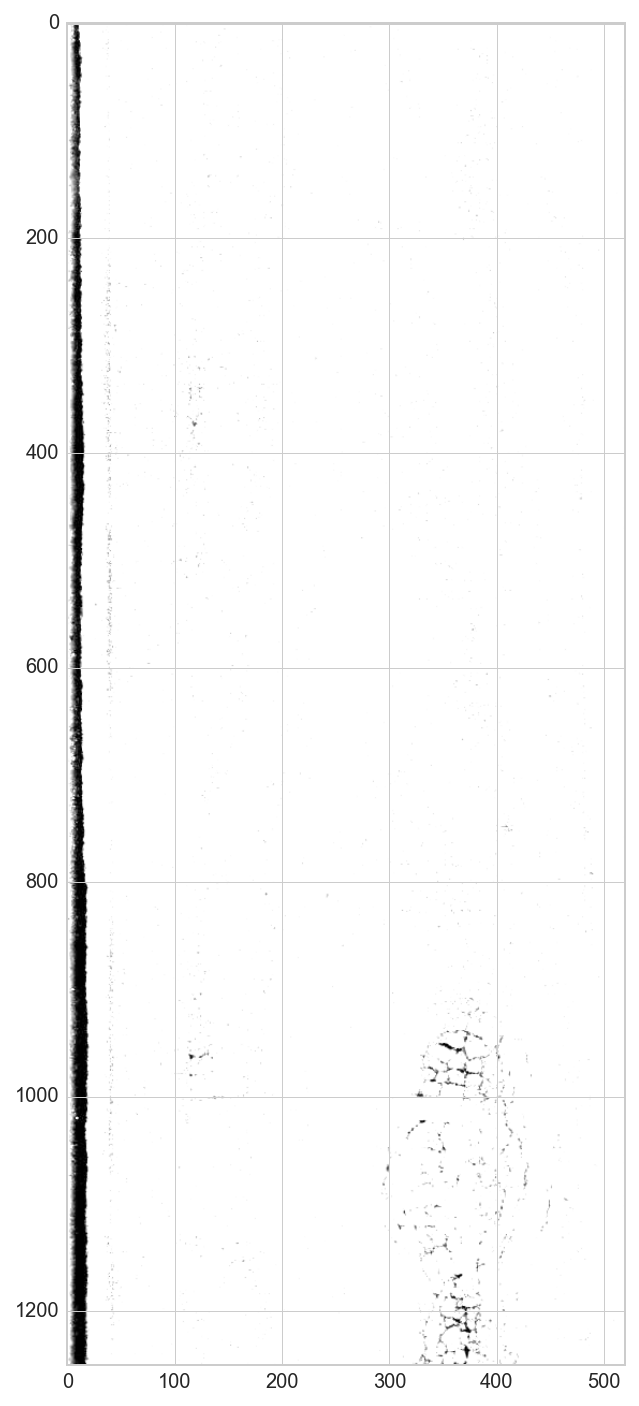

In [40]:
multiplied = np.clip(images[12] * 2.5, 0, 255).astype(int)
plt.figure(figsize=(5,12.5))
plt.imshow(multiplied)
plt.show()

$3.8\%$ of the original information remains.

In [41]:
np.prod(multiplied[multiplied != 255].shape) / np.prod(images[12].shape)

0.03813384615384616

### 2.2.4 Processing all images

Calculate the average proportion of non-255 pixels for all images:

In [42]:
prop_before = [(np.prod(img[img != 255].shape) / np.prod(img.shape)) for img in images]
np.mean(prop_before)

0.9995601025641024

Perform grayscale transformation on all images:

In [43]:
images_gf = [np.clip(img * 2.5, 0, 255).astype(int) for img in images]

Calculate the average proportion of non-255 pixels for all images after transformation:

In [44]:
prop_after = [(np.prod(img[img != 255].shape) / np.prod(img.shape)) for img in images_gf]
np.mean(prop_after)

0.017803935897435896

## 2.3 Crop

### 2.3.1 Determine the Crop Size

The original size:

In [45]:
images[0].shape

(1250, 520, 3)

We need to crop the images, the reasons include:

> **1.** We can see from the sample images in **2.2.2** and **2.2.3** that some of dark pixel noises cannot be removed simply by grascale transformation. Fortunately, most of the noises are at the edge of the images and most of the crackes are located in the middle of the images. We can remove the noise by cut them out.
>
> **2.** Most pre-trained model in transfer learning requires input images in the shape of square and of size less than 300 $\times$ 300 (usually, 224 $\times$ 224). However, our crack images is rectangular and the size is multiple of the required input. We need to cut them into small pieces.

Basically, we wish to crop the one original image into a 410 $\times$ 1230 images which containes three 410 $\times$ 410 small images as illustrated below:

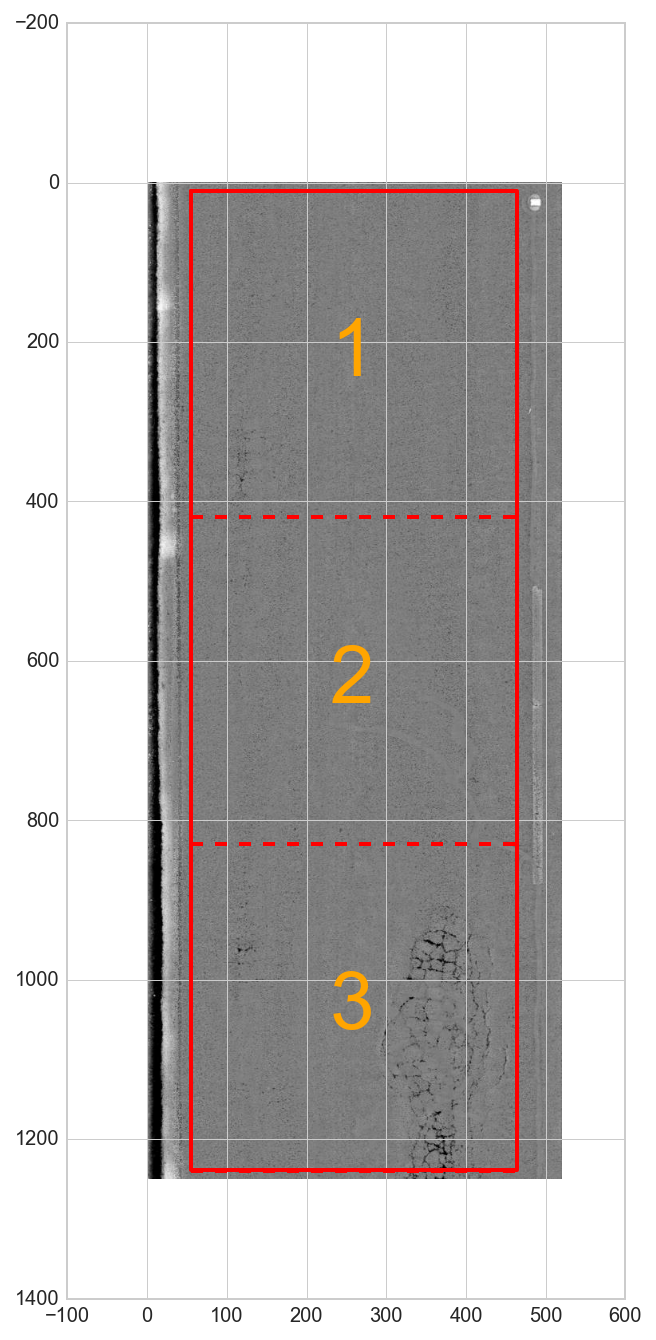

In [46]:
ideal_shape = (1230, 410, 3)
crop_bound = {
    "xmin": int((images[0].shape[1] - ideal_shape[1]) / 2),
    "xmax": int((images[0].shape[1] + ideal_shape[1]) / 2 - 1),
    "ymin": int((images[0].shape[0] - ideal_shape[0]) / 2),
    "ymax": int((images[0].shape[0] + ideal_shape[0]) / 2 -1)
}
y_space = np.linspace(crop_bound["ymin"], crop_bound["ymax"] + 1, 4).astype(int)

plt.figure(figsize=(5,12.5))
plt.imshow(images[12])
x = [crop_bound["xmin"]] + [crop_bound["xmax"]] * 2 + [crop_bound["xmin"]] * 2
y = [crop_bound["ymin"]] * 2 + [crop_bound["ymax"]] * 2 + [crop_bound["ymin"]]
plt.plot(x, y, c="red", linewidth="2")
for i in range(1, len(y_space)):
    if i != 5:
        plt.plot((crop_bound["xmin"], crop_bound["xmax"]), (y_space[i], y_space[i]), color="r", linestyle="--")
    plt.text((crop_bound["xmin"] + crop_bound["xmax"]) / 2 - 30, (y_space[i - 1] + y_space[i]) / 2, 
             i, color="orange", fontsize=40, ma="center", va="center")
plt.show()

The question is how likely for the **whole** cracks falls out-side of the range of this range (it seems to be ok if just a part of the crack is outside). We can check this in the XML annotation:

There are in total 303 crackes in the sample:

In [47]:
sample_crack_count = 0
edge_crack_count = 0
for xml in xml_list:
    with open(os.path.join(ANNO_PATH, xml)) as file:
        soup = BeautifulSoup(file.read(), 'xml')
        objects = soup.find_all("object")
        sample_crack_count += len(objects)
        for crack in objects:
            box = crack.bndbox
            box = {
                'xmin': int(box.xmin.text), 
                'xmax': int(box.xmax.text), 
                'ymin': int(box.ymin.text), 
                'ymax': int(box.ymax.text)
            }
            if (box["xmin"] > crop_bound["xmax"] or
                box["xmax"] < crop_bound["xmin"] or
                box["ymin"] > crop_bound["ymax"] or
                box["ymax"] < crop_bound["ymin"]):
                edge_crack_count += 1
    
sample_crack_count

303

Of which 5 crackes will be cut out.

In [48]:
edge_crack_count

6

The cracks cut out accounts for roughly 2% of the total crack. It is reasonably accetable.

In [49]:
edge_crack_count / sample_crack_count

0.019801980198019802

To decide which crop size is most suitable, we can plot the wide of image after being cropped (520 to 310) against the proprotion of crack that will be cut out, as well as the length of image after bing cropped (1250 to 1000) against the proprotion of crack that is cut out.

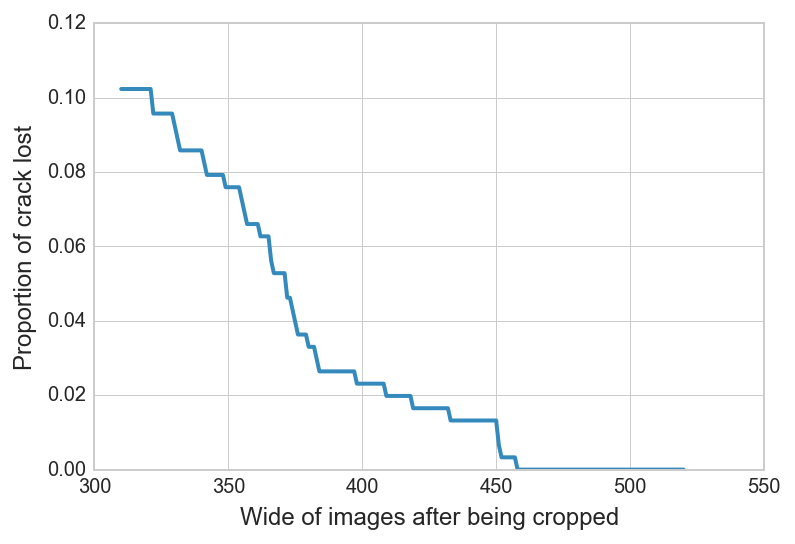

In [50]:
wide = np.arange(310, 521)
length = np.arange(1000, 1250)
crop_bounds_wide = [{
                    "xmin": int((images[0].shape[1] - i) / 2),
                    "xmax": int((images[0].shape[1] + i) / 2 - 1)
                } for i in wide]
crop_bounds_length = [{
                    "ymin": int((images[0].shape[0] - i) / 2),
                    "ymax": int((images[0].shape[0] + i) / 2 - 1)
                } for i in length]
sample_crack_count = 0
edge_crack_count_wide = np.zeros(len(wide))
edge_crack_count_length = np.zeros(len(length))
for xml in xml_list:
    with open(os.path.join(ANNO_PATH, xml)) as file:
        soup = BeautifulSoup(file.read(), 'xml')
        objects = soup.find_all("object")
        sample_crack_count += len(objects)
        for crack in objects:
            box = crack.bndbox
            box = {
                'xmin': int(box.xmin.text), 
                'xmax': int(box.xmax.text),
                'ymin': int(box.ymin.text), 
                'ymax': int(box.ymax.text) 
            }
            for idx, crop_bound in enumerate(crop_bounds_wide):
                if (box["xmin"] > crop_bound["xmax"] or
                    box["xmax"] < crop_bound["xmin"]):
                    edge_crack_count_wide[idx] += 1
            for idx, crop_bound in enumerate(crop_bounds_length):
                if (box["ymin"] > crop_bound["ymax"] or
                    box["ymax"] < crop_bound["ymin"]):
                    edge_crack_count_length[idx] += 1

plt.figure()
plt.plot(wide, edge_crack_count_wide / sample_crack_count)
plt.xlabel('Wide of images after being cropped')
plt.ylabel('Proportion of crack lost')
plt.show()

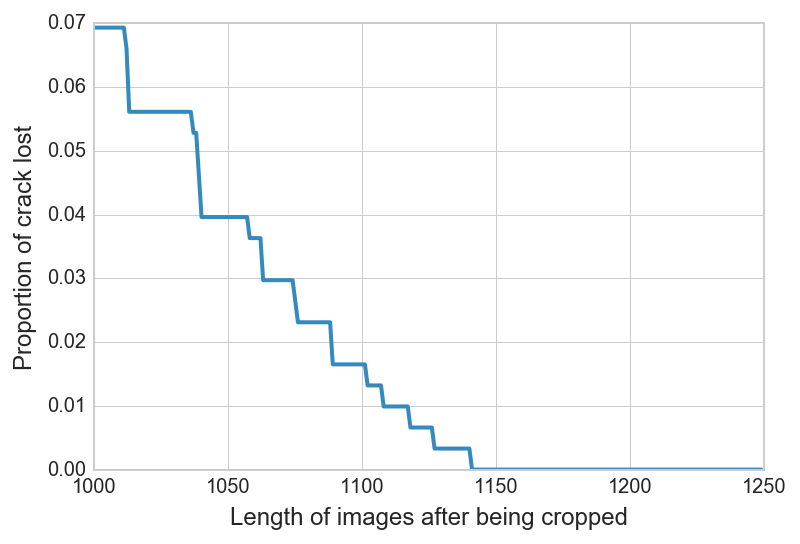

In [51]:
plt.figure()
plt.plot(length, edge_crack_count_length / sample_crack_count)
plt.xlabel('Length of images after being cropped')
plt.ylabel('Proportion of crack lost')
plt.show()

We can see the any wide > 400 and any length > 1100 is OK for the proportion of crack to be cut out stays below roughly 2%.

So, our choice of 420 $\times$ 1240 is acceptable.

### 2.3.2 Crop all Images

Crop all original images:

In [52]:
ideal_shape = (1230, 410, 3)
crop_bound = {
    "xmin": int((images[0].shape[1] - ideal_shape[1]) / 2),
    "xmax": int((images[0].shape[1] + ideal_shape[1]) / 2 - 1),
    "ymin": int((images[0].shape[0] - ideal_shape[0]) / 2),
    "ymax": int((images[0].shape[0] + ideal_shape[0]) / 2 -1)
}

images_cropped = [img[crop_bound["ymin"]:crop_bound["ymax"] + 1, crop_bound["xmin"]:crop_bound["xmax"] + 1] for img in images]

images_cropped[0].shape

(1230, 410, 3)

We can see the noises at the edge in original sample image from **2.2.3** has been removed

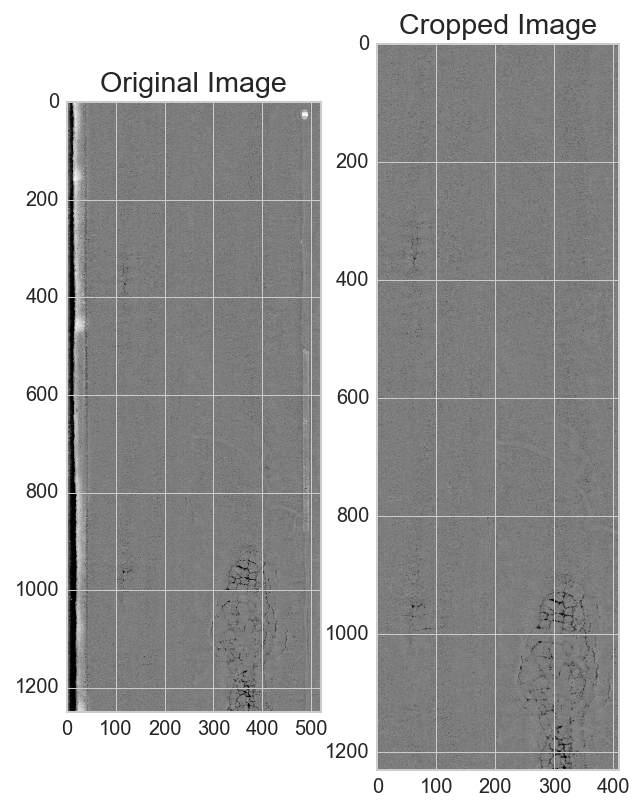

In [53]:
plt.figure(figsize=(5, 6.5))
plt.subplot(121)
plt.imshow(images[12])
plt.title("Original Image")
plt.subplot(122)
plt.imshow(images_cropped[12])
plt.title("Cropped Image")
plt.show()

Then we can split the cropped image into 3 sqaure 410 $\times$ 410 images:

In [54]:
y_space = np.linspace(0, ideal_shape[0], 4).astype(int)
y_space[-1] += 1

images_split = [[img[y_space[i]:y_space[i + 1],] for i in range(len(y_space) - 1)] for img in images_cropped]

Check whether the images are corretly split.

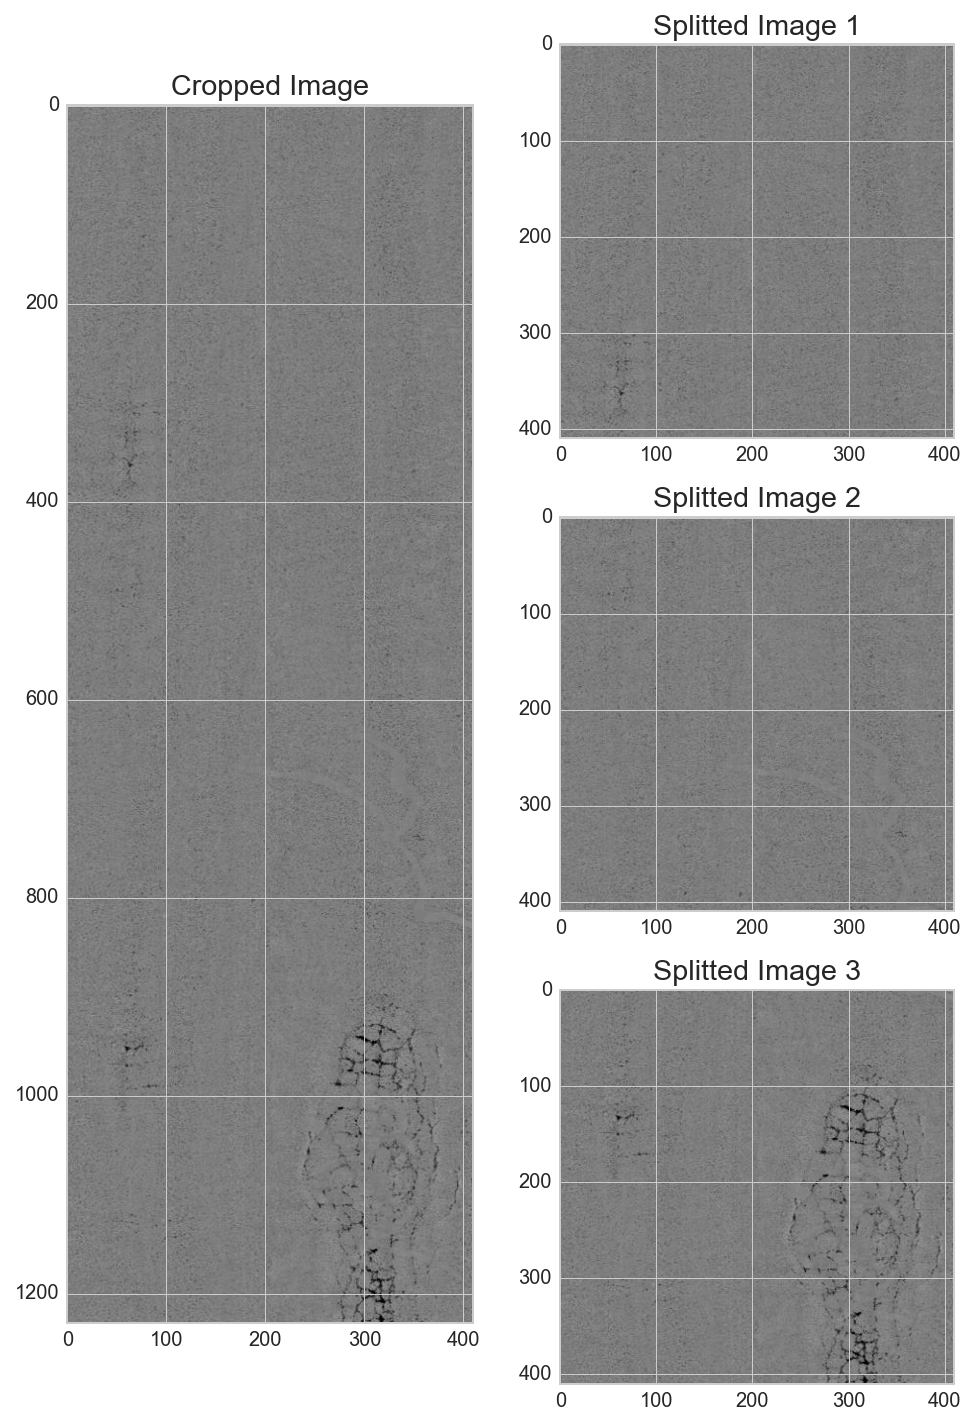

In [55]:
plt.figure(figsize=(8, 12))
plt.subplot(1,2,1)
plt.imshow(images_cropped[12])
plt.title("Cropped Image")
for i in range(1, 4):    
    plt.subplot(3,2,i * 2)
    plt.imshow(images_split[12][i - 1])
    plt.title(f"Splitted Image {i}")
plt.show()

We can overlay the 3 images by taking the minimum of each pixel:

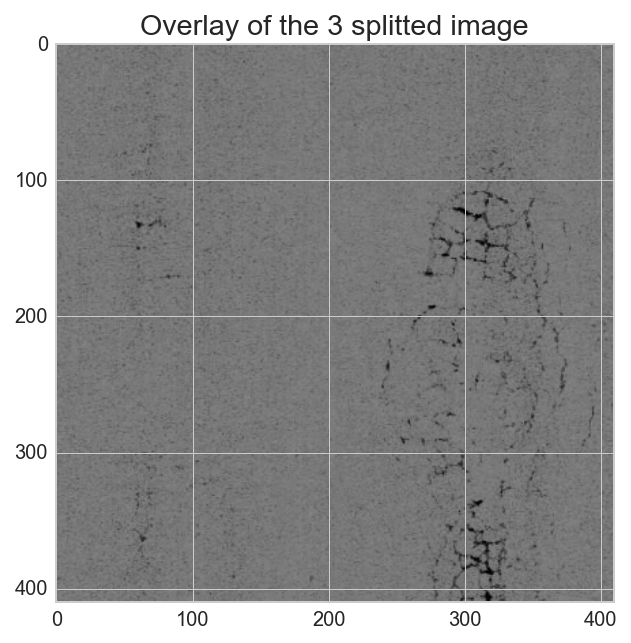

In [56]:
images_overlay = [np.minimum(np.minimum(img[0], img[1]), img[2]) for img in images_split]

plt.figure(figsize=(5, 5))
plt.imshow(images_overlay[12])
plt.title("Overlay of the 3 splitted image")
plt.show()

In [57]:
images_overlay[0].shape

(410, 410, 3)

Then we can resize the image to 224 $\times$ 224.

In [58]:
images_overlay_resized = [np.array(Image.fromarray(np.uint8(img)).resize((224,224))).astype(int) for img in images_overlay]

images_overlay_resized[0].shape

(224, 224, 3)

Have a look at the exmaple:

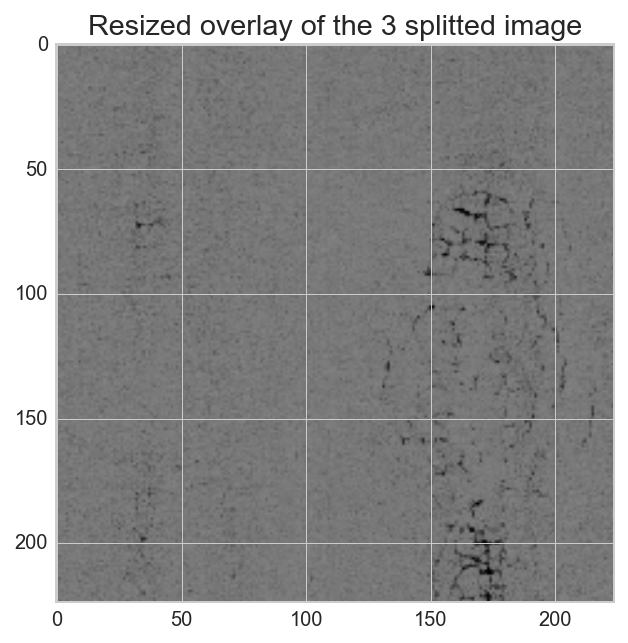

In [59]:
plt.figure(figsize=(5, 5))
plt.imshow(images_overlay_resized[12])
plt.title("Resized overlay of the 3 splitted image")
plt.show()

# 3. Extract Coordinate Information

In [60]:
long_deg, long_min, long_sec, lat_deg, lat_min, lat_sec = [], [], [], [], [], []

for filename in filenames:
    img = Image.open(os.path.join(IMG_PATH, filename))
    meta = list(img._getexif().items())[0][1]
    long_deg.append(meta[2][0][0])
    long_min.append(meta[2][1][0])
    long_sec.append(meta[2][2][0] / meta[2][2][1])
    lat_deg.append(meta[4][0][0])
    lat_min.append(meta[4][1][0])
    lat_sec.append(meta[4][2][0] / meta[2][2][1])

coord = pd.DataFrame({
    "long_deg": long_deg,
    "long_min": long_min,
    "long_sec": long_sec,
    "lat_deg": lat_deg,
    "lat_min": lat_min,
    "lat_sec": lat_sec
})

coord

long_deg  long_min   long_sec  lat_deg  lat_min    lat_sec
0          37        52  18.253463      144       36  43.190090
1          37        47  46.331328      144       28  55.343493
2          37        54   8.406514      144       38  59.545577
3          37        51   0.829885      144       34  53.461668
4          37        53  45.740082      144       38  14.333410
..        ...       ...        ...      ...      ...        ...
115        37        51  14.810467      144       59   1.094136
116        37        53  43.404107      144       38   9.919712
117        37        53  47.300934      144       38  17.441049
118        37        42  57.813529      144       52  34.331568
119        37        43   8.051500      144       57  39.889143

[120 rows x 6 columns]